# Train HeterSUMGraphe

In [31]:
import pandas as pd
import argparse
from time import time
import torch
import numpy as np
import random
from sklearn.utils import shuffle
import json
import os
import networkx as nx
import torch_geometric
from statistics import mean
import matplotlib.pyplot as plt

from tqdm import tqdm

from utils.create_graph_dataset import create_graph_dataset
from utils.GloveMgr import GloveMgr
from utils.DataLoader import DataLoader

In [32]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

## (Hyper-)parameters

In [33]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=3)
parser.add_argument('-epochs',type=int,default=100)
parser.add_argument('-dataset',type=str,default="data/nyt_corpus_LDC2008T19_50.json")

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [34]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "glove.6B.300"

# hyper-parameters
vocab_size = 50000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 5e-4
early_stopping = 3
word_blacklist_proportion = 0.1
model_name = "HeterSUMGraph"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}__early_stopping__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num, early_stopping)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_proportion_of_sentences_per_document = 0.2670278281534701
average_number_of_sentences_per_document = 6.061850780738518

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 0
epochs 100
batch_size 3


## PyTorch initialisation

In [35]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [36]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060


In [37]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## load data

In [38]:
df = pd.read_json(args.dataset)
#df = shuffle(df)

df_test = df.iloc[0:3452]
df_val = df.iloc[3452:7452]
df_train = df.iloc[7452:8000]

In [39]:
glovemgr = GloveMgr("./data/glove.6B/glove.6B.300d.txt", vocab_size=vocab_size)

In [40]:
tfidfs_sent = pd.read_json("data/nyt50_sent_tfidf.json")
tfidfs_sent = tfidfs_sent["tfidf"].to_numpy()

In [41]:
tfidfs_dataset = json.load(open("./data/nyt50_dataset_tfidf.json"))
tfidfs_dataset_sorted = sorted(tfidfs_dataset, key=tfidfs_dataset.get)
word_blacklist = set(tfidfs_dataset_sorted[:int(word_blacklist_proportion*len(tfidfs_dataset_sorted))])

In [42]:
train_dataset = create_graph_dataset(df=df_train, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="docs", labels_column_name="labels", is_sep_n=False, remove_stop_word = False, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)
val_dataset = train_dataset # create_graph_dataset(df=df_val, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="docs", labels_column_name="labels", is_sep_n=False, remove_stop_word = False, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)
test_dataset = train_dataset # create_graph_dataset(df=df_test, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="docs", labels_column_name="labels", is_sep_n=False, remove_stop_word = False, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)

In [43]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Graph stats

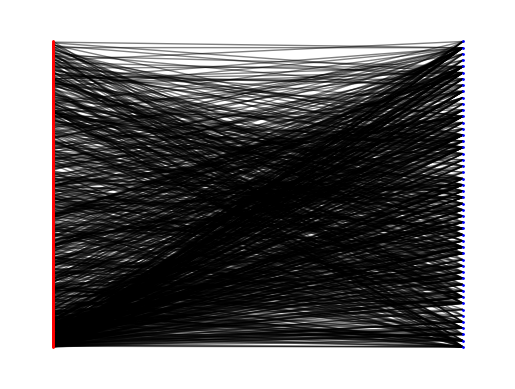

In [44]:
# draw one graph
if is_notebook():
  data = train_dataset.dataset[0]['docs']
  #g = torch_geometric.utils.to_networkx(data)
  #nx.draw(g, node_color= [0 for _ in data.x[0]] + [1 for _ in data.x[1]])
  # Convert to networkx
  G = nx.Graph()
  G.add_nodes_from(range(data.x[0].shape[0]), bipartite=0)
  G.add_nodes_from(range(data.x[1].shape[0]), bipartite=0)
  edge_list = data.edge_index.transpose(0, 1).tolist()
  G.add_edges_from(edge_list)
  # draw
  pos = nx.bipartite_layout(G, nodes=range(data.x[0].shape[0]))
  nx.draw_networkx_nodes(G, pos, nodelist=range(data.x[0].shape[0]), node_color='r', node_size=1)
  nx.draw_networkx_nodes(G, pos, nodelist=range(data.x[0].shape[0], data.x[0].shape[0] + data.x[1].shape[0]), node_color='b', node_size=1)
  nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='k')
  plt.axis('off')
  plt.show()
  

In [45]:
# Average number of distinct word per doc
print("Average number of distinct word per doc:", mean([len(t["docs"].x[0]) for t in train_dataset]))

Average number of distinct word per doc: 378.80474452554745


In [46]:
def sents_len(doc):
  return [sum([w != 0 for w in s]) for s in doc]

# Average sentence length
lens = []
for t in train_dataset:
  lens = lens + sents_len(t["docs"].x[1].numpy())

print("Average sentence len:", mean(lens))

Average sentence len: 23


In [47]:
# Average density
def density(g):
  nb_edges = g.num_edges / 2
  nb_nodes = g.num_nodes
  nb_poss_edges = nb_nodes * (nb_nodes - 1) / 2
  return nb_edges / nb_poss_edges

print("Average density:", mean([density(t["docs"]) for t in train_dataset]))

Average density: 0.009816252838499578


/home/rsaid/anaconda3/lib/python3.9/site-packages/torch_geometric/data/storage.py:280: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'x', 'undirected', 'edge_attr', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [48]:
# Average clustering
def average_clustering(g):
  G = nx.Graph()
  edge_list = g.edge_index.t().tolist()
  G.add_edges_from(edge_list)
  return nx.average_clustering(G)

print("Average clustering:", mean([average_clustering(t["docs"]) for t in train_dataset]))

Average clustering: 0.0


## Model

In [49]:
import torch.nn as nn

In [50]:
# own HEADGAT
class HeadGAT(nn.Module):
  def __init__(self, d_hi, d_hj, hidden_size = 64, d_e = 50) -> None:
    super(HeadGAT, self).__init__()
    self.Wq = nn.Linear(in_features=d_hi, out_features=hidden_size, bias=False)
    self.Wk = nn.Linear(in_features=d_hj, out_features=hidden_size, bias=False)
    self.Wa = nn.Linear(in_features=2*hidden_size+d_e, out_features=1, bias=False)
    self.leaky_relu = nn.LeakyReLU()
    self.Wv = nn.Linear(in_features=d_hj, out_features=d_hi, bias=False)

  # hi <- hj (edges orientations)
  def forward(self, Hi, Hj, edge_index_i, edge_index_j, first_i, first_j, edge_attr):
    Q = self.Wq(Hi)
    K = self.Wk(Hj)
    U = []

    # Compute N

    v, c = torch.unique(edge_index_i, return_counts=True, sorted=True)

    tmp_v = torch.arange(Hi.shape[0]).to(Hi.device)
    tmp_c = torch.zeros(Hi.shape[0], dtype=torch.long).to(Hi.device)

    tmp_c[v - first_i] = c
    c = tmp_c

    tmp_v[v - first_i] = v
    v = tmp_v   

    degree_max = torch.max(c).item()
    
    idxN = torch.zeros(Hi.shape[0] * degree_max, dtype=torch.long).to(Hi.device)
    mask_idxN = torch.arange(degree_max).to(Hi.device).repeat(Hi.shape[0])
    v_idx_sort = torch.argsort(v)
    cn_idxN = torch.repeat_interleave(c[v_idx_sort], degree_max)
    mask_idxN = mask_idxN < cn_idxN

    edge_index_i_argsort = torch.argsort(edge_index_i)
    idxN[mask_idxN] = edge_index_j[edge_index_i_argsort] - first_j

    N = K[edge_index_j[edge_index_i_argsort] - first_j]

    # Compute E

    E = edge_attr[edge_index_i_argsort]

    # Compute T
    T = torch.repeat_interleave(Q, repeats=c[torch.argsort(v)], dim=0)

    # Compute A
    A = torch.cat([T, N, E], dim=1)
    A = self.Wa(A)

    # Compute Z
    Z = self.leaky_relu(A)

    # Compute alpha
    alpha_1 = torch.exp(Z).squeeze(1)
    alpha_2 = torch.zeros(Hi.shape[0] * degree_max).to(Hi.device)
    alpha_2[mask_idxN] = alpha_1

    alpha_3 = alpha_2.view(Hi.shape[0], degree_max)

    sum_alpha_ = torch.sum(alpha_3, dim=1)
    sum_alpha = sum_alpha_.clone()
    sum_alpha[sum_alpha_ == 0] = 1
    sum_alpha = torch.repeat_interleave(sum_alpha, repeats=degree_max, dim=0)
    alpha = alpha_2 / sum_alpha

    # Compute U
    V = self.Wv(Hj)
    V = V[idxN]

    alpha = alpha.unsqueeze(1)

    U_ = alpha * V
    U_ = U_.view(Hi.shape[0], degree_max, U_.shape[1])
    U = torch.sum(U_, dim=1)
    U = torch.relu(U)

    return U


In [51]:
# own GAT
class GAT(nn.Module):
  def __init__(self, d_hi, d_hj, hidden_size = 64, d_e = 50, num_head=8) -> None:
    super(GAT, self).__init__()
    self.heads = nn.ModuleList([HeadGAT(d_hi,d_hj,hidden_size,d_e) for _ in range(num_head)])

  # hi <- hj (edges orientations)
  def forward(self, Hi, Hj, edge_index_i, edge_index_j, first_i, first_j, edge_attr):
    U = [head(Hi, Hj, edge_index_i, edge_index_j, first_i, first_j, edge_attr) for head in self.heads]
    U = torch.cat(U, dim=1)
    return U

In [52]:
# Position Feed Forward
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_in, d_out, d_h, dropout=0.1) -> None:
    super(PositionwiseFeedForward, self).__init__()
    self.fc1 = nn.Linear(in_features=d_in, out_features=d_h)
    self.fc2 = nn.Linear(in_features=d_h, out_features=d_out)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    return self.fc2(x)

In [53]:
class HeterSUMGraph(torch.nn.Module):
  def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 300, num_iter=3):
    super(HeterSUMGraph, self).__init__()
    self.device = device
    self.num_iter = num_iter

    self.word_emb = nn.Embedding(vocab_size+2, dim_word_embed, padding_idx=0)

    # Load word embedding if specified
    if word_embed is not None:
      self.word_embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(word_embed).float())

    self.word_emb.weight.requires_grad = False

    # edge_attr embed
    self.edge_attr_embed = nn.Embedding(101, 50)

    # sent CNN
    dim_out_cnn = 64
    self.convs = nn.Sequential(
                            nn.Conv1d(in_channels=300,out_channels=100,kernel_size=3,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=100,kernel_size=4,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=dim_out_cnn,kernel_size=5,padding='same'),
                            nn.BatchNorm1d(num_features=dim_out_cnn),
                            nn.ReLU(inplace=True))

    # sent LSTM
    dim_out_lstm = 32
    self.sent_LSTM = nn.LSTM(input_size=300, hidden_size=dim_out_lstm, batch_first=True, bidirectional=True)

    # sent to word GAT
    self.s2wGAT = GAT(d_hi=300, d_hj=128, hidden_size=64, d_e=50, num_head=8)

    # word to sen GAT
    self.w2sGAT = GAT(d_hi=128, d_hj=300, hidden_size=64, d_e=50, num_head=8)

    # ffn sent to word
    self.ffns2w = PositionwiseFeedForward(d_in=8*300, d_out=300, d_h=512)

    # ffn word to sent
    self.ffnw2s = PositionwiseFeedForward(d_in=8*128, d_out=128, d_h=512)

    self.wh = nn.Linear(128, 2)

  def max_pool1d(self, x, seq_lens):
    out = []
    for index,t in enumerate(x):
      if seq_lens[index] == 0:
        t = t[:1]
      else:
        t = t[:seq_lens[index],:]
      t = torch.t(t).unsqueeze(0)
      out.append(torch.avg_pool1d(t, t.size(2)))

    out = torch.cat(out).squeeze(2)
    return out

  def forward(self, data):# In the real implémentation remove nb_sent
    # edge attr embeddings
    edge_attr = torch.floor(data.edge_attr * 100).int()
    edge_attr = self.edge_attr_embed(edge_attr)

    # features
    Xw = data.x[0]
    Xs = data.x[1]
    sent_lens = torch.sum(torch.sign(Xs),dim=1).data
    
    # embeddings
    Xw = self.word_emb(Xw)
    Xs = self.word_emb(Xs)

    # CNN
    XsCNN = self.convs(Xs.permute(0,2,1))
    XsCNN = torch.max_pool1d(XsCNN, XsCNN.size(2)).squeeze(2)

    # LSTM
    # TO DO: ask 
    XsLSTM, _ = self.sent_LSTM(Xs)
    XsLSTM = self.max_pool1d(XsLSTM, sent_lens)
    Xs = torch.cat((XsCNN, XsLSTM), dim=1)

    Hw = Xw
    Hs = Xs

    edge_index_w_i = data.edge_index[1][data.edge_index[1] < len(data.x[0])]
    edge_index_s_j = data.edge_index[0][data.edge_index[1] < len(data.x[0])]
    edge_attr_w = edge_attr[data.edge_index[1] < len(data.x[0])]

    edge_index_s_i = data.edge_index[1][data.edge_index[1] >= len(data.x[0])]
    edge_index_w_j = data.edge_index[0][data.edge_index[1] >= len(data.x[0])]
    edge_attr_s = edge_attr[data.edge_index[1] >= len(data.x[0])]

    for i in range(self.num_iter):
      if i != 0: # H^1w = H^0w = Xw
        Hw = self.s2wGAT(Hi=Hw, Hj=Hs, edge_index_i=edge_index_w_i, edge_index_j=edge_index_s_j, first_i=0, first_j=len(data.x[0]), edge_attr=edge_attr_w) + torch.cat([Hw] * 8, dim=1)
        Hw = self.ffns2w(Hw)

      Hs = self.w2sGAT(Hi=Hs, Hj=Hw, edge_index_i=edge_index_s_i, edge_index_j=edge_index_w_j, first_i=len(data.x[0]), first_j=0, edge_attr=edge_attr_s) + torch.cat([Hs] * 8, dim=1)
      Hs = self.ffnw2s(Hs)

    res = self.wh(Hs)

    return res

In [54]:
model = HeterSUMGraph(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings(), dim_word_embed=300).to(device=device)

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
criterion = nn.CrossEntropyLoss()

## Train

In [57]:
if not os.path.exists(checkpoints_folder):
  os.makedirs(checkpoints_folder)

In [58]:
arr_train_loss = []
arr_val_loss = []

t1 = time()

for epoch in range(1, epochs+1):
  model.train()
  nb_batch_train = 0
  total_train_loss = 0

  with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
    for batch in tepoch:
      tepoch.set_description(f"Epoch {epoch}")
      #doc_lens = batch["doc_lens"]
      data = batch["docs"].to(device)
      targets = torch.tensor(batch["labels"], dtype=torch.long).to(device)
      y_pred = model(data)

      loss = criterion(y_pred, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()
      nb_batch_train += 1
      tepoch.set_postfix(loss=total_train_loss/nb_batch_train)
t2 = time()
print("Training duration =", t2-t1)

Epoch 1:   0%|          | 0/183 [00:01<?, ?batch/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!